# PR: Adding LogSoftmax layer to Darknet for Cross Entropy Loss

Wayne Nixalo - 2018/4/24

## 0. Proposed Change; Setup

Dataset is the fast.ai ImageNet sampleset. Jupyter kernel restarted between ImageNet learner runs due to model size.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from fastai.conv_learner import *
# from fastai.models import darknet

Current Darknet, and Proposed Changes:

**NOTE**: `from .layers import *` changed to **`from fastai.layers import *`**, preventing ModuleNotFoundError.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai.layers import *  ###  <<<------

class ConvBN(nn.Module):
    "convolutional layer then batchnorm"

    def __init__(self, ch_in, ch_out, kernel_size = 3, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(ch_out, momentum=0.01)
        self.relu = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x): return self.relu(self.bn(self.conv(x)))

class DarknetBlock(nn.Module):
    def __init__(self, ch_in):
        super().__init__()
        ch_hid = ch_in//2
        self.conv1 = ConvBN(ch_in, ch_hid, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvBN(ch_hid, ch_in, kernel_size=3, stride=1, padding=1)

    def forward(self, x): return self.conv2(self.conv1(x)) + x

class Darknet(nn.Module):
    "Replicates the darknet classifier from the YOLOv3 paper (table 1)"

    def make_group_layer(self, ch_in, num_blocks, stride=1):
        layers = [ConvBN(ch_in,ch_in*2,stride=stride)]
        for i in range(num_blocks): layers.append(DarknetBlock(ch_in*2))
        return layers

    def __init__(self, num_blocks, num_classes=1000, start_nf=32):
        super().__init__()
        nf = start_nf
        layers = [ConvBN(3, nf, kernel_size=3, stride=1, padding=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=(1 if i==1 else 2))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x): return self.layers(x)

########################
### Proposed Version ###
class PR_Darknet(nn.Module):
    "Replicates the darknet classifier from the YOLOv3 paper (table 1)"

    def make_group_layer(self, ch_in, num_blocks, stride=1):
        layers = [ConvBN(ch_in,ch_in*2,stride=stride)]
        for i in range(num_blocks): layers.append(DarknetBlock(ch_in*2))
        return layers

    def __init__(self, num_blocks, num_classes=1000, start_nf=32):
        super().__init__()
        nf = start_nf
        layers = [ConvBN(3, nf, kernel_size=3, stride=1, padding=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=(1 if i==1 else 2))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        layers += [nn.LogSoftmax()] ###  <<<------
        self.layers = nn.Sequential(*layers)

    def forward(self, x): return self.layers(x)
### /Proposed Version ###
########################
    
def darknet_53(num_classes=1000):    return Darknet([1,2,8,8,4], num_classes)
def darknet_small(num_classes=1000): return Darknet([1,2,4,8,4], num_classes)
def darknet_mini(num_classes=1000): return Darknet([1,2,4,4,2], num_classes, start_nf=24)
def darknet_mini2(num_classes=1000): return Darknet([1,2,8,8,4], num_classes, start_nf=16)
def darknet_mini3(num_classes=1000): return Darknet([1,2,4,4], num_classes)

# demonstrator
def PR_darknet_53(num_classes=1000):    return PR_Darknet([1,2,8,8,4], num_classes)

In [4]:
def display_head(fastai_learner, λ_name=None, show_nums=False):
    """displays final conv block and network head."""
    # parse
    if λ_name == None: 
        λ_name='DarknetBlock'
        fastai_learner = fastai_learner[0]
    if show_nums:
        fastai_learner = str(fastai_learner).split('\n')
        n = len(fastai_learner)
    else:
        n = len(str(fastai_learner).split('\n'))
        
    j = 1
    # find final conv block
    for i in range(n):
        if λ_name in str(fastai_learner[-j]): break
        j += 1
    # print head & 'neck'
    for i in range(j):
        print(fastai_learner[i-j])
        
# don't mind the λ's.. l's alone look too much like 1's
# It's easy to switch keyboards on a Mac or Windows (ctrl/win-space)
# fn NOTE: the `learner[0]` for Darknet is the same as `learner`
#          for other models; hence the if/else logic to keep printouts neat
#          show_nums displays layer numbers - kinda

In [5]:
PATH = Path('data/imagenet')

In [6]:
sz = 256
bs = 32

In [7]:
tfms = tfms_from_stats(imagenet_stats, sz)

In [8]:
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, val_name='train')

## 1. fastai Darknet Loss Function

### Darknet without LogSoftmax layer and with NLL loss

In [9]:
f_model = darknet_53()

In [10]:
learner = ConvLearner.from_model_data(f_model, model_data)

fastai.conv_learner logic sets criterion to [torch.nn.functional.nll_loss](https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py#L1294-L1294):

In [11]:
learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

There is no final activation layer. The criterion will be applied to the final layer's output:

In [12]:
display_head(learner)

DarknetBlock(
  (conv1): ConvBN(
    (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.01, affine=True)
    (relu): LeakyReLU(0.1, inplace)
  )
  (conv2): ConvBN(
    (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.01, affine=True)
    (relu): LeakyReLU(0.1, inplace)
  )
)
AdaptiveAvgPool2d(output_size=1)
Flatten(
)
Linear(in_features=1024, out_features=1000, bias=True)


In this case the Learning Rate Finder 'fails' due to very small - often negative - loss values.

  2%|▏         | 14/608 [01:07<47:44,  4.82s/it, loss=0.0192] 

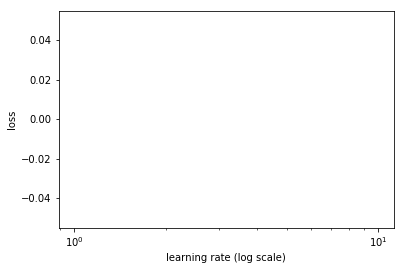

In [13]:
learner.lr_find()
learner.sched.plot()

Sometimes the LR Finder manages to produce a plot, but the results leave much to be desired:

  3%|▎         | 18/608 [01:22<44:56,  4.57s/it, loss=0.0269]   

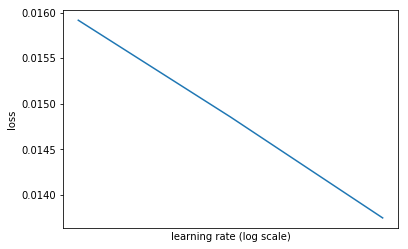

In [15]:
learner.lr_find()
learner.sched.plot()

### Darknet with Cross Entropy loss

In [9]:
f_model = darknet_53()

In [10]:
learner = ConvLearner.from_model_data(f_model, model_data, crit=F.cross_entropy)

In [11]:
learner.crit

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

There is no final activation layer. The criterion will be applied to the final layer's output:

In [12]:
display_head(learner)

DarknetBlock(
  (conv1): ConvBN(
    (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.01, affine=True)
    (relu): LeakyReLU(0.1, inplace)
  )
  (conv2): ConvBN(
    (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.01, affine=True)
    (relu): LeakyReLU(0.1, inplace)
  )
)
AdaptiveAvgPool2d(output_size=1)
Flatten(
)
Linear(in_features=1024, out_features=1000, bias=True)


 91%|█████████ | 553/608 [39:49<03:57,  4.32s/it, loss=39.8]

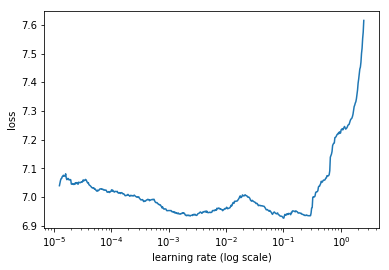

In [13]:
learner.lr_find()
learner.sched.plot()

This is the shape of plot we expect to see.

### Proposal: Darknet with LogSoftmax layer and NLL loss (Cross Entropy loss)

In [9]:
f_model = PR_darknet_53()

In [10]:
learner = ConvLearner.from_model_data(f_model, model_data)

fastai.conv_learner logic sets criterion to [torch.nn.functional.nll_loss](https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py#L1294-L1294):

In [11]:
learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

However [cross_entropy](https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py#L1408-L1442) *is* NLL(LogSoftmax). The final layer is a LogSoftmax activation. The NLL criterion applied to its output will produce a Cross Entropy loss function.

In [12]:
display_head(learner)

DarknetBlock(
  (conv1): ConvBN(
    (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.01, affine=True)
    (relu): LeakyReLU(0.1, inplace)
  )
  (conv2): ConvBN(
    (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.01, affine=True)
    (relu): LeakyReLU(0.1, inplace)
  )
)
AdaptiveAvgPool2d(output_size=1)
Flatten(
)
Linear(in_features=1024, out_features=1000, bias=True)
LogSoftmax()


 92%|█████████▏| 562/608 [40:30<03:18,  4.32s/it, loss=32.8]

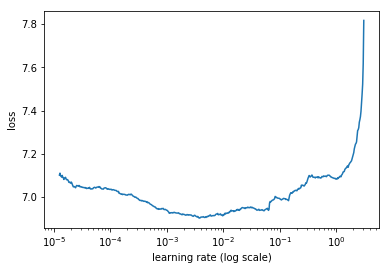

In [13]:
learner.lr_find()
learner.sched.plot()

## 2. Learner Comparison: ResNet18 & DarkNet53

In working on this, I found some behavior that seemed odd, but may be normal. The CIFAR-10 dataset from fast.ai will be used here.

In [9]:
from fastai.conv_learner import *

In [10]:
PATH = Path('data/cifar10')

In [11]:
sz = 64 # darknet53 architecture can't handle 32x32 small input
bs = 64
tfms = tfms_from_stats(imagenet_stats, sz)
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, val_name='test')

A version of darknet.py with the proposed changes above is used. 

In [12]:
from fastai.models import darknet

Comparing resnet18 from PyTorch to resnet18 from FastAI:

In [13]:
from torchvision.models import resnet18

In [14]:
resnet18

<function torchvision.models.resnet.resnet18(pretrained=False, **kwargs)>

The fastai library does not alter the resnet18 model it imports from PyTorch.

For comparison, the darknet53 import from fastai looks like this:

In [15]:
darknet.darknet_53

<function fastai.models.darknet.darknet_53(num_classes=1000)>

By contrast, the types of the initialized models:

In [16]:
type(resnet18(num_classes=10))

torchvision.models.resnet.ResNet

In [17]:
type(darknet.darknet_53(num_classes=10))

fastai.models.darknet.Darknet

The PyTorch ResNet18 model has no output activation layer.

In [18]:
f_model = resnet18()

In [19]:
display_head(str(f_model), λ_name='BasicBlock', show_nums=True)

    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (avgpool): AvgPool2d(kernel_size=7, stride=7, padding=0, ceil_mode=False, count_include_pad=True)
  (fc): Linear(in_features=512, out_features=1000, bias=True)
)


When a learner is intialized via `ConvLearner.pretrained`, the fastai library adds a classifier head to the model via the `ConvnetBuilder` class. 

**NOTE** that the definition of the model is passed in, and *not* a model object.

In [20]:
learner = ConvLearner.pretrained(resnet18, model_data)

In [21]:
display_head(learner, λ_name='BasicBlock', show_nums=True)

    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (8): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=(1, 1))
    (mp): AdaptiveMaxPool2d(output_size=(1, 1))
  )
  (9): Flatten(
  )
  (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (11): Dropout(p=0.25)
  (12): Linear(in_features=1024, out_features=512, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (15): Dropout(p=0.5)
  (16): Linear(in_features=512, out_features=10, bias=True)
  (17): LogSoftmax()
)


***the fastai library adds the necessary LogSoftmax layer to the end of the model***

**NOTE**: default constructor for resnet18 & darknet is 1000 classes (ImageNet). fastai lib finds the correct `num_classes` from the `ModelData` object. That's why the resnet18 model above has 1000 output features, and the resnet18 learner below it has the correct 10.

The criterion, the loss function, of the learner is still `F.nll_loss`:

In [22]:
learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

But since the final layer is an `nn.LogSoftmax`, the effective loss function is Cross Entropy.

**NOTE** that this does **not** happen when the learner is initalized via `.from_model_data`:

In [23]:
learner = ConvLearner.from_model_data(resnet18(num_classes=10), model_data)

In [24]:
display_head(learner, λ_name='BasicBlock', show_nums=True)

    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (avgpool): AvgPool2d(kernel_size=7, stride=7, padding=0, ceil_mode=False, count_include_pad=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)


### 'Strange/Normal' behavior:

`ConvLearner.pretrained` will only accept model definitions, **not** models themselves:

In [25]:
learner = ConvLearner.pretrained(resnet18, model_data)

In [26]:
learner = ConvLearner.pretrained(resnet18(num_classes=10), model_data)

AttributeError: 'bool' object has no attribute 'dim'

However the current version of Darknet is not accepted by `ConvLearner.pretrained` at all. This makes sense, given that the model is not yet pretrained, but also suggests further work is needed to integrate the model into the library.

In [27]:
learner = ConvLearner.pretrained(darknet.darknet_53, model_data)

TypeError: torch.FloatTensor constructor received an invalid combination of arguments - got (bool, int), but expected one of:
 * no arguments
 * (int ...)
      didn't match because some of the arguments have invalid types: ([31;1mbool[0m, [31;1mint[0m)
 * (torch.FloatTensor viewed_tensor)
 * (torch.Size size)
 * (torch.FloatStorage data)
 * (Sequence data)


In [28]:
learner = ConvLearner.pretrained(darknet.darknet_53(num_classes=10), model_data)

AttributeError: 'bool' object has no attribute 'dim'

The `from_model_data` method works, as seen in section 1.

---

## Misc

In [378]:
# Use this version of `display_head` if the other is too finicky for you.
# NOTE: fastai learners other than darknet will have to be entered as:
#       [str(learner_or_model).split('\n')]

def display_head(fastai_learner, λ_name=None):
    """displays final conv block and network head."""
    n = len(fastai_learner[0])
    if λ_name == None: λ_name='DarknetBlock'
    j = 1
    # find final conv block
    for i in range(n):
        if λ_name in str(fastai_learner[0][-j]): break
        j += 1
    # print head & 'neck'
    for i in range(j):
        print(fastai_learner[0][i-j])

# display_head(learner, λ_name='BasicBlock')
display_head(learner1) #darknet learner
print('--------')
display_head([str(learner2).split('\n')], λ_name='BasicBlock') #resnet learner
print('--------')
display_head([str(f_model).split('\n')], λ_name='BasicBlock') #resnet model

DarknetBlock(
  (conv1): ConvBN(
    (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.01, affine=True)
    (relu): LeakyReLU(0.1, inplace)
  )
  (conv2): ConvBN(
    (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.01, affine=True)
    (relu): LeakyReLU(0.1, inplace)
  )
)
AdaptiveAvgPool2d(output_size=1)
Flatten(
)
Linear(in_features=1024, out_features=1000, bias=True)
--------
    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (8): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=(